# ANKRD11

[KBG syndrome (KBGS)](https://omim.org/entry/148050) is caused by heterozygous mutation in the ANKRD11 gene. In this notebook, we have used
[pyphetools](https://github.com/monarch-initiative/pyphetools) to parse the clinical data included in the supplemental files of
[Martinez-Cayuelas E, et al. Clinical description, molecular delineation and genotype-phenotype correlation in 340 patients with KBG syndrome: addition of 67 new patients](https://pubmed.ncbi.nlm.nih.gov/36446582).

The authors identified a significantly higher frequency of patients with a triangular face in carriers of sequence variants compared to CNVs. Other associations found were short stature and variants in exon 9, a lower incidence of ID/ADHD/ASD in carriers of the c.1903_1907del variant and the size of the deletion, in CNV carriers, with the presence of macrodontia and hand anomalies.

In [2]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


### ANKRD11
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ANKRD11.

In [3]:
gene_symbol = 'ANKRD11'
mane_tx_id = 'NM_013275.6'
mane_protein_id = 'NP_037407.4' # ankyrin repeat domain-containing protein 11 [Homo sapiens]

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

Loaded 337 phenopackets
Individuals Processed:  20%|██        | 68/337 [00:56<03:44,  1.20individuals/s]


HTTPError: 429 Client Error: TOO MANY REQUESTS for url: https://rest.variantvalidator.org/VariantValidator/tools/gene2transcripts/HGNC:21316

In [5]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Macrodontia,HP:0001572,211
Intellectual disability,HP:0001249,194
Abnormality of the hand,HP:0001155,189
Global developmental delay,HP:0001263,176
Delayed speech and language development,HP:0000750,160
Short stature,HP:0004322,150
Thick eyebrow,HP:0000574,126
Long philtrum,HP:0000343,121
Bulbous nose,HP:0000414,89
Triangular face,HP:0000325,83


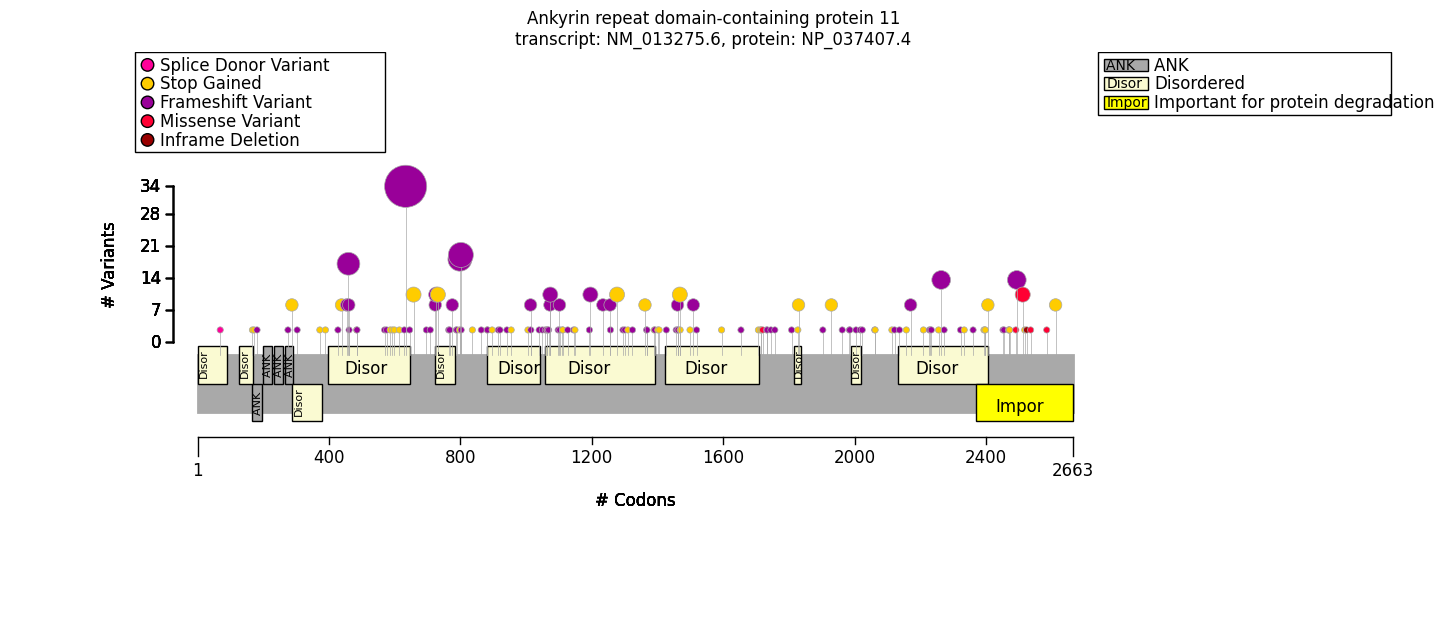

In [7]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

#protein_meta = ProteinMetadata.from_uniprot_json(
#        protein_id=mane_protein_id,
#        label="NKX6-2",
#        uniprot_json="Q9C056.json",
#        protein_length=550,
#)

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [9]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)


Name,Type,Coordinates,Count,Variants
Disordered,REGION,1 - 90,0,
Disordered,REGION,128 - 169,1,p.Glu169Ter
ANK 1,REPEAT,167 - 196,3,p.Arg183ProfsTer44; p.Arg174Ter; p.Glu169Ter
ANK 2,REPEAT,200 - 229,0,
ANK 3,REPEAT,233 - 262,0,
ANK 4,REPEAT,266 - 292,3,p.Tyr289Ter; p.Thr278ArgfsTer3
Disordered,REGION,289 - 380,2,p.Glu374Ter; p.Pro306HisfsTer62
Disordered,REGION,398 - 647,60,p.Thr462LysfsTer47; p.Arg595_Gln596delinsSerTer; p.Ser588Ter; p.Glu461GlnfsTer48; p.Thr571AlafsTer15; p.Glu616Ter; p.Asp578Ter; p.Arg440Ter; p.Ser486Ter; p.Ser647LeufsTer6; p.Glu487ValfsTer22; p.Gly464ArgfsTer29; p.Ser429GlyfsTer8; p.Arg601Ter; p.Lys456SerfsTer53; p.His632ThrfsTer2; p.Lys635GlnfsTer26
Disordered,REGION,723 - 783,12,p.Glu777ArgfsTer5; p.Lys766ArgfsTer10; p.Ser769GlnfsTer8; p.Ile728GlnfsTer13; p.Arg733Ter; p.Asn725LysfsTer23
Disordered,REGION,881 - 1043,12,p.Glu922AlafsTer6; p.Arg898Ter; p.Ile1042TrpfsTer275; p.Asp1016IlefsTer302; p.Glu883Ter; p.Glu956Ter; p.Arg1007Ter; p.Glu943ValfsTer74; p.Glu918Ter; p.Asp884ThrfsTer93


# Strategy
Here, we will perform a version of the tests based on tests performed in [Martinez-Cayuelas E,et al., (2023) Clinical description, molecular delineation and genotype-phenotype correlation in 340 patients with KBG syndrome: addition of 67 new patients. J Med Genet](https://pubmed.ncbi.nlm.nih.gov/36446582/)

In [15]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant

abl_pred = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, mane_tx_id)
gt_predicate = autosomal_dominant(abl_pred)

In [16]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,8
HMF04,Skipping term because all genotypes have same HPO observed proportions,99
HMF06,Skipping term with less than 7 observations (not powered for 2x2),8
HMF08,Skipping general term,53


In [13]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                          HOM_REF            HET  \
                                                      Count Percent  Count   
Umbilical hernia [HP:0001537]                          0/49      0%    2/9   
Triangular face [HP:0000325]                         71/102     70%  12/26   
Ventricular septal defect [HP:0001629]               12/146      8%   6/28   
Microretrognathia [HP:0000308]                        16/52     31%   7/11   
Intrauterine growth retardation [HP:0001511]          14/64     22%   7/15   
Synophrys [HP:0000664]                                54/97     56%  14/18   
Microcephaly [HP:0000252]                            34/119     29%   8/47   
Attention deficit hyperactivity disorder [HP:00...    53/68     78%   8/14   
Mandibular prognathia [HP:0000303]                    13/47     28%    0/7   
Short stature [HP:0004322]                          118/196     60%  32/63   
Low anterior hairline [HP:0000294]                    56/89     63%   6/14   
Delayed skeletal maturation [HP:0002750]             54/115     47%   9/14   
Bulbous nose [HP:0000414]                            79/115     69%  10/18   
Sleep abnormality [HP:0002360]                        19/57     33%   6/12   
Cryptorchidism [HP:0000028]                           35/83     42%   7/12   
Autistic behavior [HP:0000729]                        42/75     56%  14/21   
Low-set ears [HP:0000369]                             21/41     51%    3/9   
EEG abnormality [HP:0002353]                          17/50     34%   3/13   
Recurrent otitis media [HP:0000403]                   24/54     44%   7/12   
Long philtrum [HP:0000343]                          108/134     81%  13/18   
Hypotonia [HP:0001252]                                22/54     41%   7/13   
Intellectual disability [HP:0001249]                162/188     86%  32/35   
Motor delay [HP:0001270]                              56/79     71%  13/20   
Strabismus [HP:0000486]                               17/71     24%    3/9   
Global developmental delay [HP:0001263]             135/142     95%  41/42   
Exaggerated cupid's bow [HP:0002263]                  13/47     28%   2/11   
Prominent nose [HP:0000448]                           17/41     41%   3/10   
Anteverted nares [HP:0000463]                         67/92     73%   9/13   
Protruding ear [HP:0000411]                           52/71     73%  18/23   
Delayed speech and language development [HP:000...  124/144     86%  36/43   
Macrodontia [HP:0001572]                            174/218     80%  37/47   
Feeding difficulties [HP:0011968]                    59/136     43%  11/26   
Thick eyebrow [HP:0000574]                          109/134     81%  17/21   
Hypertelorism [HP:0000316]                           59/101     58%   9/16   
Generalized-onset seizure [HP:0002197]                13/15     87%    5/6   
Febrile seizure (within the age range of 3 mont...      5/8     62%    1/1   
Generalized non-motor (absence) seizure [HP:000...      3/8     38%    0/1   
Focal-onset seizure [HP:0007359]                       8/14     57%    2/4   

What is the genotype group                                                     \
                                                   Percent Corrected p values   
Umbilical hernia [HP:0001537]                          22%           0.590119   
Triangular face [HP:0000325]                           46%           0.590119   
Ventricular septal defect [HP:0001629]                 21%           0.590119   
Microretrognathia [HP:0000308]                         64%           0.726491   
Intrauterine growth retardation [HP:0001511]           47%           0.726491   
Synophrys [HP:0000664]                                 78%           0.726491   
Microcephaly [HP:0000252]                              17%           0.726491   
Attention deficit hyperactivity disorder [HP:00...     57%           0.726491   
Mandibular prognathia [HP:0000303]                      0%           

In [1]:
from phenotype_scorer import Ankrd11PhenotypeScorer